# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [47]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

# Principal Agent model for forsikring I

**Write out the model in equations here.** 

Make sure you explain well the purpose of the model and comment so that other students who may not have seen it before can follow.  

The agent is a consumer whos utility depends on consumption $c$ given by the utility function $v(c)$.  
The agents consumption depends on income $M$ and whether or not he experiences "accidents". 

If the agent experiences accidents he loses a portion of his income denoted by $L$

with probability $\pi$ he experiences an accident and gets: 

$$
c = M - L
$$

with probability $(1-\pi)$ he does not experience accidents and gets: 

$$
c = M
$$

The principal is an insurance company, that sells insurances with a price $\Gamma$ and payment of $K$;

The agent pays the price and following scenarios can happen;

with probability of $\pi$ the agent experiences an accident and loses $L$, but gets the insurance payment of $K$, Thus

$$
c = M - \Gamma - L + K
$$

with probability 1-$\pi$ the agent does not experience accidents and gets: 

$$
c = M - \Gamma 
$$

The agent has two options,

To sign the insurance contract with the principal, or to choose the outside option denoted by $\overline{v}$

$$
\overline{v} = \pi * v(M-L) + (1-\pi) * v(M)
$$

we assume the agent maximizes utility and we assume $v' > 0$ and $v'' < 0$,
which means that the agent likes to consume and would like to avoid risks. 

We also assume that the principal maximizes expected utility. 

We can now write up our principal agent problem, where $\Gamma - K$ is profit for the principal without accidents and $\Gamma$ is the profit without accidents.
$$
\max_{\Gamma, K} \pi * (\Gamma - K) + (1-\pi) * \Gamma\\

s.t. \\


\pi * v(M - \Gamma - L + K) + (1 - \pi) * v(M - \Gamma) \underline{>} \overline{v}
$$ 

The contraint ensures that the agents utility by accepting the insurance contract is atleast as big as the utility he gets from choosing the outside option, when the function is maximized. 

## Analytical solution

If your model allows for an analytical solution, you should provide here.

You may use Sympy for this. Then you can characterize the solution as a function of a parameter of the model.

To characterize the solution, first derive a steady state equation as a function of a parameter using Sympy.solve and then turn it into a python function by Sympy.lambdify. See the lecture notes for details. 

We start by defining $c_1 = M - \Gamma$ as consumption with out accident and $c_2 = M - \Gamma - L + K$ as consumption with accident.

Note that if we choose a particular $\Gamma$ and $K$ we can find $c_1$ and $c_2$ directly, and vice versa if we choose a particular $c_1$ and $c_2$.

There by we can expresse the principal-Agent problem as following, 
$$
\max_{c_1,c_2} M - \pi \cdot L - (1-\pi)c_1 - \pi c_2 \\
s.t. \\
\pi \cdot v(c_2) + (1-\pi) \cdot v(c_1) \geq \overline{v} 
$$

In [48]:
from modelproject import define_symbols, calculate_derivatives, solve_equations

# Definer symbolerne
L, M, pi, c_1, c_2, lam, v_overline, v = define_symbols()

# Beregn derivaterne og opret ligninger
principal, condition, lagrange, Lc_1, Lc_2, Llam, v_diff_c1, v_diff_c2 = calculate_derivatives(L, M, pi, c_1, c_2, lam, v_overline, v)

#passer 

1. We see that the second order condition must be binding
$$
\pi \cdot v(c_2) + (1-\pi) \cdot v(c_1) = \overline{v} 
$$
2. and then we solve the problem using lagrange.

In [49]:
print('L = ')
display(lagrange)

L = 


-L*pi + M - c_1*(1 - pi) - c_2*pi + lambda*(-\overline{v} + pi*v(c_2) + (1 - pi)*v(c_1))

Find the first order derivatives

In [50]:
display(Lc_1)
display(Lc_2)
display(Llam)

Eq(0, lambda*(1 - pi)*Derivative(v(c_1), c_1) + pi - 1)

Eq(0, lambda*pi*Derivative(v(c_2), c_2) - pi)

Eq(0, -\overline{v} + pi*v(c_2) + (1 - pi)*v(c_1))

We solve for $\frac{d}{dc_1}v(c_1)$ and $\frac{d}{dc_2}v(c_2)$

In [51]:
# Solve the system of equations
solution = solve_equations(Lc_1, Lc_2, Llam, v_diff_c1, v_diff_c2)

# check for a solution
if isinstance(solution, dict):
    for var, sol in solution.items():
        eq = sm.Eq(var, sol)
        display(eq)
elif isinstance(solution, list) and solution:
    for sol in solution:
        display(sol)
else:
    print("No solutions found.")

Eq(Derivative(v(c_1), c_1), 1/lambda)

Eq(Derivative(v(c_2), c_2), 1/lambda)

Meaning that optimal contract includes that $c_1 = c_2$. Since $c_1 = M - \Gamma$ can we write $c_2 = M - \Gamma - L + K \Leftrightarrow c_2 = c_1 - L + K \Leftrightarrow L = c_1 - c_2 + K$ which means that $L = K$.

## Numerical solution

You can always solve a model numerically. 

Define first the set of parameters you need. 

Then choose one of the optimization algorithms that we have gone through in the lectures based on what you think is most fitting for your model.

Are there any problems with convergence? Does the model converge for all starting values? Make a lot of testing to figure these things out. 

In [52]:
def parameter(K, gamma, pi):
    M = 50
    L = 5
    rho = 0.95

    # Compute consumptions
    c1 = M - gamma
    c2 = M - gamma - L + K

    return M, L, pi, rho, c1, c2

def principal_problem(x, pi):
    K, gamma = x
    M, L, pi, rho, c1, c2 = parameter(K, gamma, pi)
    return -(M - pi * L - (1 - pi) * c1 - pi * c2)

def agent_utility(c, rho):
    return c**(1 - rho) / (1 - rho)

def constraint(x, pi):
    K, gamma = x
    M, L, pi, rho, c1, c2 = parameter(K, gamma, pi)
    return pi * agent_utility(c2, rho) + (1 - pi) * agent_utility(c1, rho) - (pi * agent_utility(M - L, rho) + (1 - pi) * agent_utility(M, rho))

def optimize_for_pi(pi_value):
    initial_guess_K_gamma = [2, 2]  # Initial guess for K and gamma

    # Define bounds for K and gamma
    bounds = [(0, None), (0, None)]  # K >= 0, gamma >= 0

    # Perform optimization with constraint
    result = optimize.minimize(principal_problem, initial_guess_K_gamma, args=(pi_value,),
                               method='SLSQP', bounds=bounds,
                               constraints={'type': 'ineq', 'fun': constraint, 'args': (pi_value,)},
                               options={'maxiter': 1000})

    K, gamma = result.x
    return K, gamma, result.success

# Define a range of possible values for pi
pi_values = np.linspace(0.01, 0.98, 11)  # e.g., 11 values from 0 to 1

# Loop over all pi values and store results
results = []
for pi_val in pi_values:
    K, gamma, success = optimize_for_pi(pi_val)
    if success:
        results.append((pi_val, K, gamma))
    else:
        results.append((pi_val, None, None))

pi_values_t = []
gamma_values_t = []
K_values_t = []

for res in results:
    pi_val, K, gamma = res
    if K is not None and gamma is not None:
        pi_values_t.append(pi_val)
        gamma_values_t.append(gamma)
        K_values_t.append(K)

# Print the results
print("Optimal values:")
for res in results:
    pi_val, K, gamma = res
    if K is not None and gamma is not None:
        print(f"For pi = {pi_val:.2f}, K: {K:.2f}, gamma: {gamma:.2f}")
    else:
        print(f"For pi = {pi_val:.2f}, optimization did not converge.")

#print(results)


Optimal values:
For pi = 0.01, K: 5.00, gamma: 0.05
For pi = 0.11, K: 5.00, gamma: 0.56
For pi = 0.20, K: 5.00, gamma: 1.06
For pi = 0.30, K: 5.00, gamma: 1.56
For pi = 0.40, K: 5.00, gamma: 2.05
For pi = 0.49, K: 5.00, gamma: 2.54
For pi = 0.59, K: 5.00, gamma: 3.02
For pi = 0.69, K: 5.00, gamma: 3.50
For pi = 0.79, K: 5.00, gamma: 3.97
For pi = 0.88, K: 5.00, gamma: 4.44
For pi = 0.98, K: 5.02, gamma: 4.92


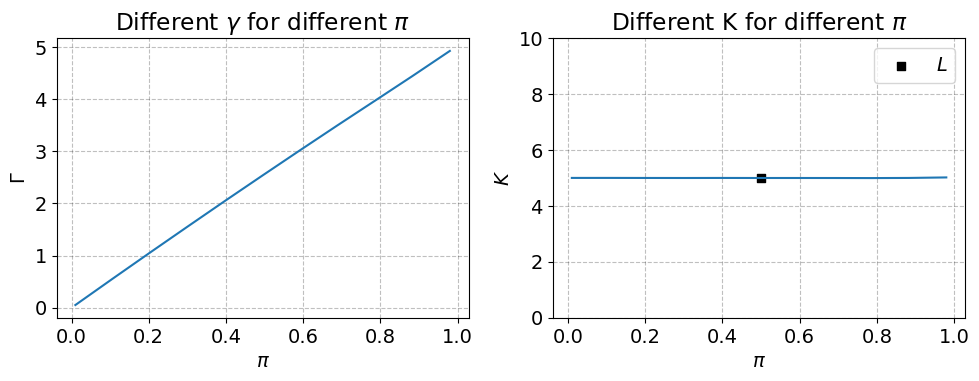

In [53]:
fig = plt.figure(figsize=(10,4))

# First subplot for gamma vs pi
ax = fig.add_subplot(1,2,1)
ax.plot(pi_values_t, gamma_values_t, linestyle='-')  # Make sure you have these lists ready from your results
ax.set_xlabel('$\pi$')
ax.set_ylabel('$\Gamma$')
ax.set_title('Different $\gamma$ for different $\pi$')

# Second subplot for K vs pi
ax2 = fig.add_subplot(1,2,2)
ax2.plot(pi_values_t, K_values_t, linestyle='-')  # Assuming you have these lists from your optimization results
ax2.scatter(0.5, 5, marker='s', color='black', label='$L$')  # Example, adjust 'L' as needed
ax2.set_xlabel('$\pi$')
ax2.set_ylabel('$K$')
ax2.set_title('Different K for different $\pi$')
ax2.set_ylim([0, 10])

# Include legend if necessary
ax2.legend()

fig.tight_layout(pad=1.0)
plt.show()

# Further analysis

Make detailed vizualizations of how your model changes with parameter values. 

Try to make an extension of the model. 

In [67]:
# model med selvrisiko 

def parameter(K, gamma):
    M = 50
    L = 2
    rho = 0.95
    pi_s = 0.3
    pi_f = 0.1
    e = 1

    # Compute consumptions
    c1 = M - gamma
    c2 = M - gamma - L + K

    return M, L, rho, c1, c2, e, pi_s, pi_f

def principal_problem_s(x):
    K, gamma = x
    M, L, rho, c1, c2, pi_s, pi_f, e = parameter(K, gamma)
    return -(M - pi_s * L - (1 - pi_s) * c1 - pi_s * c2)

def principal_problem_f(x):
    K, gamma = x
    M, L, rho, c1, c2, pi_s, pi_f, e = parameter(K, gamma)
    return -(M - pi_f * L - (1 - pi_f) * c1 - pi_f * c2)


def agent_utility(c, rho):
    return c**(1 - rho) / (1 - rho)

def constraint_s(x):
    K, gamma = x
    M, L, rho, c1, c2, pi_s, pi_f, e = parameter(K, gamma)
    return pi_s * agent_utility(c2, rho) + (1 - pi_s) * agent_utility(c1, rho) - (pi_s * agent_utility(M - L, rho) + (1 - pi_s) * agent_utility(M, rho))

def constraint_f(x):
    K, gamma = x
    M, L, rho, c1, c2, pi_s, pi_f, e = parameter(K, gamma)
    return pi_f * agent_utility(c2, rho) + (1 - pi_f) * agent_utility(c1, rho) - e - (pi_s * agent_utility(M - L, rho) + (1 - pi_s) * agent_utility(M, rho))

def constraint_ic(x):
    K, gamma = x
    M, L, rho, c1, c2, pi_s, pi_f, e = parameter(K, gamma)
    return (pi_s - pi_f)*(agent_utility(c1, rho)-agent_utility(c2, rho)) - e 
    

initial_guess_K_gamma = [1, 1]  # Initial guess for K and gamma

# Define bounds for K and gamma
bounds = [(0, None), (0, None)]  # K >= 0, gamma >= 0

# Perform optimization with constraint
results_s = optimize.minimize(principal_problem_s, initial_guess_K_gamma, 
                           method='SLSQP', bounds=bounds, 
                           constraints=[{'type': 'ineq', 'fun': constraint_s},{'type': 'ineq', 'fun': constraint_ic}], options={'maxiter': 1000})

# Perform optimization with constraint
results = optimize.minimize(principal_problem_f, initial_guess_K_gamma, 
                           method='SLSQP', bounds=bounds, 
                           constraints=[{'type': 'ineq', 'fun': constraint_f},{'type': 'ineq', 'fun': constraint_ic}], options={'maxiter': 1000})


K, gamma = results_s['x']
print("Optimal values:")
print(f"K: {K:.2f}")
print(f"gamma: {gamma:.2f}")


Optimal values:
K: 1.00
gamma: 1.00


In [54]:
#første model
def parameter(K, gamma):
    M = 50
    L = 5
    pi = 0.2
    pi_f = 0.1
    rho = 0.95

    # Compute consumptions
    c1 = M - gamma
    c2 = M - gamma - L + K

    return M, L, pi, pi_f rho, c1, c2

def principal_problem(x):
    K, gamma = x
    M, L, pi, rho, c1, c2 = parameter(K, gamma)
    return -(M - pi * L - (1-pi) * c1 - pi * c2)

def agent_utility(c, rho):
    return c**(1 - rho) / (1 - rho)

def constraint(x):
    K, gamma = x
    M, L, pi, rho, c1, c2 = parameter(K, gamma)
    return pi * agent_utility(c2, rho) + (1-pi) * agent_utility(c1, rho) -(pi * agent_utility(M - L, rho) + (1 - pi) * agent_utility(M, rho))

initial_guess_K_gamma = [2, 2]  # Initial guess for K and gamma

# Define bounds for K and gamma
bounds = [(0, None), (0, None)]  # K >= 0, gamma >= 0

# Perform optimization with constraint
result = optimize.minimize(principal_problem, initial_guess_K_gamma, method='SLSQP', bounds=bounds, constraints={'type': 'ineq', 'fun': constraint}, options={'maxiter': 1000})


K, gamma = result['x']
print("Optimal values:")
print(f"K: {K:.2f}")
print(f"gamma: {gamma:.2f}")

Optimal values:
K: 5.00
gamma: 1.04


# Conclusion

Add concise conclusion. 